# Minimum Edit Distance

In [25]:
def del_cost(letter):
    return 1
    
def ins_cost(letter):
    return 1

def sub_cost(letter1, letter2):
    if letter1 == letter2:
        return 0
    return 2

def min_edit(word1, word2, del_cost, ins_cost, sub_cost):
    the_matrix = [[-1 for i in range(len(word2)+1)] for j in range(len(word1)+1)]
    back_pointers = [[None for i in range(len(word2)+1)] for j in range(len(word1)+1)]
    for i in range(len(word1)+1):
        the_matrix[i][0] = i
    for j in range(len(word2) + 1):
        the_matrix[0][j] = j
        
    for i in range(1, len(word1)+1):
        for j in range(1, len(word2)+1):
            insertion_cost = the_matrix[i-1][j]+ins_cost(word1[i-1])
            deletion_cost = the_matrix[i][j-1]+del_cost(word2[j-1])
            substitution_cost = the_matrix[i-1][j-1]+sub_cost(word1[i-1], word2[j-1])
            if insertion_cost < deletion_cost:
                out_cost = insertion_cost
                back = "insert"
            else:
                out_cost = deletion_cost
                back = "delete"
            if substitution_cost <= out_cost:
                out_cost = substitution_cost
                back = "substitute"
            the_matrix[i][j] = out_cost
            back_pointers[i][j] = back
    return (the_matrix, back_pointers)

matrix, back = min_edit('hi', 'hello', del_cost, ins_cost, sub_cost)
matrix

[[0, 1, 2, 3, 4, 5], [1, 0, 1, 2, 3, 4], [2, 1, 2, 3, 4, 5]]

In [26]:
def get_alignment(back_pointers):
    i = len(back_pointers) - 1
    j = len(back_pointers[0]) - 1
    print i, j
    breaker = 100
    while True:
        if breaker < 0:
            print "breaker"
            break
        breaker -= 1
        direction = back_pointers[i][j]
        if direction == None:
            if (i == 0) and (j == 0):
                print "The end", i,j
                break
            elif i > j:
                print "insert", i, j
                i -= 1
            else:
                print "delete", i, j
                j -= 1
        elif direction == "substitute":
            print "Substitute", i, j
            i -= 1
            j -= 1
        elif direction == "delete":
            print "delete", i, j
            j -= 1
        elif direction == "insert":
            print "insert", i, j
            i -= 1
        else:
            print "error"
            break
            
get_alignment(back)  

2 5
Substitute 2 5
delete 1 4
delete 1 3
delete 1 2
Substitute 1 1
The end 0 0


In [93]:
lookup = {}

def recursive(word1, word2):
    try:
        out = lookup[word1][word2]
        #print "lookup"
        return lookup[word1][word2]
    except KeyError:
        pass
    
    if len(word1) == 0:
        lookup[word1] = {word2: (len(word2),["delete" for _ in range(len(word2) )])}
        return (len(word2), ["delete" for _ in range(len(word2))])
    elif len(word2) == 0:
        lookup[word1] = {word2: (len(word1),["insert" for _ in range(len(word1) )]) }
        return (len(word1), ["insert" for _ in range(len(word1))])
    else:
        insertion_cost, insertion_path = recursive(word1[:-1], word2)
        insertion_cost += ins_cost(word1[-1])
        deletion_cost, deletion_path = recursive(word1, word2[:-1])
        deletion_cost += del_cost(word2[-1])

        substitution_cost, substitution_path = recursive(word1[:-1], word2[:-1])
        substitution_cost += sub_cost(word1[-1], word2[-1])   
        if insertion_cost < deletion_cost:
            out_cost = insertion_cost
            out_path = ["insert"]+insertion_path
            #print "insert"
        else:
            out_cost = deletion_cost
            out_path = ["delete"]+deletion_path
            #print "delete"
        if substitution_cost <= out_cost:
            out_cost = substitution_cost
            #print substitution_path
            out_path = ["substitute"]+substitution_path
            #print "substitute"
        lookup[word1][word2] = (out_cost, out_path)
        #print out_path
        return (out_cost, out_path)
            
count, backwards = recursive('execution','intention')  
print count
print list(reversed(backwards))

8
['delete', 'substitute', 'substitute', 'substitute', 'insert', 'substitute', 'substitute', 'substitute', 'substitute', 'substitute']


# Viterbi

In [2]:
import nltk
from nltk.corpus import brown

In [37]:
tags = brown.tagged_words(tagset="universal")
tags

[(u'The', u'DET'), (u'Fulton', u'NOUN'), ...]

In [38]:
len(tags)

1161192

In [107]:
tag_fd = nltk.FreqDist(tag for (word, tag) in tags)
tag_fd.most_common()

[(u'NOUN', 275558),
 (u'VERB', 182750),
 (u'.', 147565),
 (u'ADP', 144766),
 (u'DET', 137019),
 (u'ADJ', 83721),
 (u'ADV', 56239),
 (u'PRON', 49334),
 (u'CONJ', 38151),
 (u'PRT', 29829),
 (u'NUM', 14874),
 (u'X', 1386)]

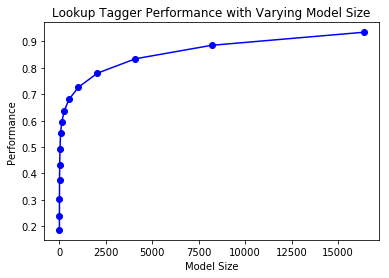

In [10]:
def performance(cfd, wordlist):
    lt = dict((word, cfd[word].max()) for word in wordlist)
    baseline_tagger = nltk.UnigramTagger(model=lt, backoff=nltk.DefaultTagger('NN'))
    return baseline_tagger.evaluate(brown.tagged_sents(categories='news'))

def display():
    import pylab
    word_freqs = nltk.FreqDist(brown.words(categories='news')).most_common()
    words_by_freq = [w for (w, _) in word_freqs]
    cfd = nltk.ConditionalFreqDist(brown.tagged_words(categories='news'))
    sizes = 2 ** pylab.arange(15)
    perfs = [performance(cfd, words_by_freq[:size]) for size in sizes]
    pylab.plot(sizes, perfs, '-bo')
    pylab.title('Lookup Tagger Performance with Varying Model Size')
    pylab.xlabel('Model Size')
    pylab.ylabel('Performance')
    pylab.show()
display()

In [26]:
nltk.FreqDist(brown.words(categories='news')).most_common()[:10]

[(u'the', 5580),
 (u',', 5188),
 (u'.', 4030),
 (u'of', 2849),
 (u'and', 2146),
 (u'to', 2116),
 (u'a', 1993),
 (u'in', 1893),
 (u'for', 943),
 (u'The', 806)]

In [27]:
cfd = nltk.ConditionalFreqDist(brown.tagged_words(categories='news', tagset="universal"))
for key in cfd.keys():
    if key == "the":
        print cfd[key]

<FreqDist with 1 samples and 5580 outcomes>


In [28]:
the = cfd["the"]
for key in the.keys():
    print key, the[key]


DET 5580


In [47]:
tags = brown.tagged_words()
flag = False
det_count = 0
noun_det_count = 0
for word, tag in tags:
    if flag:
        flag = False
        if tag == "PPSS":
            noun_det_count += 1
    if tag == "VB":
        det_count += 1
        flag = True
print noun_det_count, det_count, float(noun_det_count)/det_count       

234 33693 0.00694506277268


In [51]:
tags = brown.tagged_words()

det_count = 0
noun_det_count = 0
for word, tag in tags:
    if tag == "VB":
        det_count += 1
        if word == "race":
            noun_det_count += 1
print noun_det_count, det_count, float(noun_det_count)/det_count    

4 33693 0.000118719021755


In [55]:
sents = brown.tagged_sents()
flag = False
det_count = 0
noun_det_count = 0
noun_det_count_2 = 0
for sentence in sents:
    if sentence[0][1] == "PPSS":
        noun_det_count += 1
    for word, tag in sentence:
        if tag == "VB":
            det_count += 1
            if word == "race":
                noun_det_count_2 += 1

print noun_det_count, len(sents), float(noun_det_count)/len(sents) 
print noun_det_count_2, det_count, float(noun_det_count_2)/det_count   

3146 57340 0.0548657132892
4 33693 0.000118719021755


In [18]:
observation_like = {"VB":  {"I":0,  "want":.0093,  "to":0,   "race":.00012},
                    "TO":  {"I":0,  "want":0,      "to":0.99,"race":0}, 
                    "NN":  {"I":0,  "want":.000054,"to":0,   "race":.00057},
                    "PPSS":{"I":.37,"want":0,      "to":0,   "race":.00012}}
transition_probs = {"<s>": {"VB":.019, "TO":.0043, "NN":.041,  "PPSS":.067},
                    "VB":  {"VB":.0038,"TO":.035,  "NN":.047,  "PPSS":.007}, 
                    "TO":  {"VB":.83,  "TO":0,     "NN":.00047,"PPSS":0},
                    "NN":  {"VB":.0040,"TO":.016,  "NN":.087,  "PPSS":.0045},
                    "PPSS":{"VB":.23,  "TO":.00079,"NN":.0012, "PPSS":.00014}}
transition_order = ["PPSS","VB","TO","NN"]

In [52]:
def viterbi(tokens):
    matrix = [[-1 for i in range(len(tokens)+1)] for j in range(len(transition_order))]
    back_pointers = [[None for i in range(len(tokens)+1)] for j in range(len(transition_order))]
    
    for s in range(len(transition_order)):
        pos = transition_order[s]
        matrix[s][0] = transition_probs["<s>"][pos]*observation_like[pos][tokens[0]]
        back_pointers[s][0] = -1
        
    for t in range(1, len(tokens)):
        for s in range(len(transition_order)):
            pos = transition_order[s]
            token = tokens[t]

            best_value = -1
            for i, ss in enumerate(transition_order):
                # print pos,ss, matrix[i][t-1], transition_probs[ss][pos]
                the_viterbi_score = matrix[i][t-1]*transition_probs[ss][pos]
                if the_viterbi_score > best_value:
                    best_value = the_viterbi_score
                    back_pointers[s][t] = i
            #print best_value,t,s
            matrix[s][t] = best_value*observation_like[pos][token]
    
    best_value = -1        
    for i, ss in enumerate(transition_order):
        the_viterbi_score = matrix[i][len(matrix[0])-2]
        if the_viterbi_score > best_value:
            best_value = the_viterbi_score
            back_pointers[len(matrix)-1][len(matrix[0])-1] = i
    matrix[len(matrix)-1][len(matrix[0])-1] = best_value 
    
    output = [back_pointers[len(matrix)-1][len(matrix[0])-1]]
    for i in range(1, len(matrix[0])-1):
        j = len(matrix[0]) - i - 1
        pointer = output[-1]
        output.append(back_pointers[pointer][j])

    output.reverse()
    return [transition_order[o] for o in output]

viterbi(["I","want","to","race"])

['PPSS', 'VB', 'TO', 'VB']